# Solving First-Order Differential Equations

The code below will compare traditional methods of solving ordinary differential equations (ODE's) with solving them with neural networks. Much of this code is replicated from other research projects and slightly altered. References are below.

References:
- https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932
- https://kitchingroup.cheme.cmu.edu/blog/2017/11/28/Solving-ODEs-with-a-neural-network-and-autograd/
- https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c
- https://github.com/Rachnog/Neural-Networks-for-Differential-Equations/blob/master/ODE%20example.ipynb

In [1]:
import autograd.numpy as np # Thinly-wrapped version of Numpy
from autograd import grad, elementwise_grad
# grad finds the gradient (derivative) of a scalar-valued function; that is a function with a float-value output
# elementwise_grad finds the gradient of a function that is given a vector. So it evaluates the gradient of each element of the 
# input vector and outputs a vector of same size 
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Swish activation function is used
def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))


def approx_f(params, inputs, activation_fxn=swish):
    "Neural network function"
    "Takes in the parameters (weights & biases) but also"
    "takes in an array of inputs (discretized domain)"
    "returns an array of outputs based on the domain"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = activation_fxn(outputs)    
    return outputs

def total_error(a1, approx_a1):
    error = 0
    for i in range(len(a1)):
        term = 0
        term += abs(a1[i] - approx_a1[i])
        term /= a1[i]
        error += term
    error = sum(error) / len(a1)
    return error

def ode_nn(num_iterations, objective_fxn, init_t, actual_dfdt, f0, scale=0.1, step_size = 0.001, 
           hidden_layer_size=8, analytic_soln=0, plot=True, plot_num=1):
    """
    Function to approximate first order ode using swish activation function
    with a single input value (x), a hidden layer, and a single output 
    """

    # Here is our initial guess of params:
    params = init_random_params(scale, layer_sizes=[1, hidden_layer_size, 1])
 
    t = init_t
    
    # Using the neural net to solve 
    params = adam(grad(objective_fxn), params,
              step_size=step_size, num_iters=num_iterations, callback=callback) 
    
    # Euler's Method
    euler = []
    euler.append(f0)
    f_n = f0
    for t_n in t:
        f_n1 = float(f_n + actual_dfdt(f_n, t_n) * (t[1] - t[0]))
        euler.append(f_n1)
        f_n = f_n1
    euler.pop()
    euler = np.array(euler)
    
    if plot == True:
        print("\n")
        plt.figure(figsize=(9,9))
        if analytic_soln:
            plt.plot(t, analytic_soln(t), label="Analytic Solution", lw=2.5)
        plt.plot(t, euler, 'g-.', label="Euler's", lw=2.5)
        plt.plot(t, approx_f(params, t), 'r--', label="Neural Network Solution", lw=2.5)
        plt.xlabel("time, t")
        plt.ylabel("$ψ(t)$")
        plt.title("Neural Network solution to $dψ/dt = f(t, ψ(t))$ compared to Euler's Method")
        plt.legend()
        plt.savefig('nn-ode-' + str(plot_num) + '.png')
        plt.show()
        
        print("\n")
        print("Average Percent Error from Analytic Solution")
        print("--------------------------------------------")
        print("Neural Network:", "\t\t", round(total_error(analytic_soln(t), approx_f(params, t)) * 100, 3), "%")
        print("Euler's Method:", "\t\t", round(total_error(analytic_soln(t), euler) * 100, 3), "%")
        print("\n\n\n")
    else:
        return params

___

$df/dt = -0.23 * f(t)$

$f_0 = 2$

Iteration   0 objective [[3.95489732]]
Iteration 300 objective [[0.77115913]]
Iteration 600 objective [[0.00033623]]
Iteration 900 objective [[3.25656319e-05]]
Iteration 1200 objective [[3.2595346e-05]]




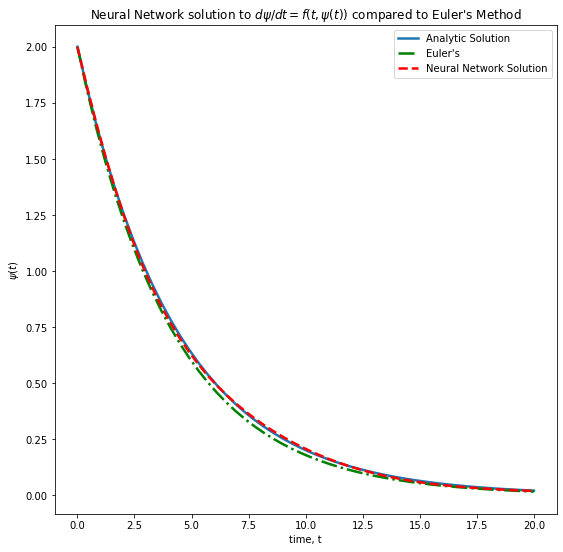



Average Percent Error from Analytic Solution
--------------------------------------------
Neural Network: 		 4.086 %
Euler's Method: 		 10.679 %






In [3]:
random.seed(6)
t = np.linspace(0, 20).reshape((-1, 1))
f0 = 2

def actual_dfdt(y, t):
    return -0.23 * y

# This is the function we seek to minimize
def obj1(params, step):
    # These should all be zero at the solution
    # This is our initial equation, df/dt = -0.23 * f(t) with f(0) = 2
    dfdt = elementwise_grad(approx_f, 1)
    zeq = dfdt(params, t) - (-0.23 * approx_f(params, t)) # returns an array [df/dt(t)] - [-0.23*approx_f(t)] 
    ic = approx_f(params, 0) - f0 # returns a scalar, basically approx_f(0) - f(0)
    return np.mean(zeq**2) + ic**2 # returns a scalar

def callback(params, step, g):
    if step % 300 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      obj1(params, step)))
def analytic_fxn1(x):
    return 2 * np.exp(-0.23 * x)

ode_nn(num_iterations=1201, objective_fxn=obj1, actual_dfdt=actual_dfdt, f0=f0,
       init_t=t, analytic_soln = analytic_fxn1, plot_num=1, scale=0.005)

___

Logistic differential equation:(Pierre-Fran ̧cois Verhulst)

$df/dt = f(t)(1 - f(t))$

$f_0 = 10$

Iteration   0 objective [[110.26139735]]
Iteration 1000 objective [[8.80284681]]
Iteration 2000 objective [[1.29531208]]
Iteration 3000 objective [[0.26077201]]




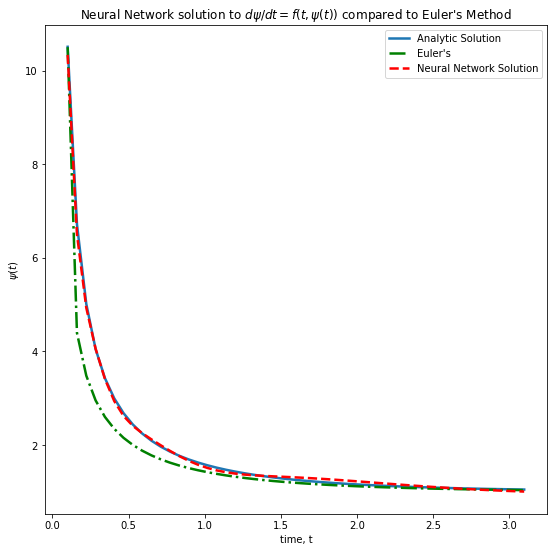



Average Percent Error from Analytic Solution
--------------------------------------------
Neural Network: 		 2.705 %
Euler's Method: 		 8.034 %






In [4]:
random.seed(2)
t = np.linspace(0.1, 3.1).reshape((-1, 1))
f0 = 10.5

def actual_dfdt(y, t):
    return y * (1 - y)

# This is the function we seek to minimize
def obj2(params, step):
    # These should all be zero at the solution
    # This is our initial equation, df/dt = f(t)(1 - f(t)) with f(0) = 10
    dfdt = elementwise_grad(approx_f, 1)
    zeq = dfdt(params, t) - (approx_f(params, t)*(1 - approx_f(params, t)))
    ic = approx_f(params, 0.1) - f0 # returns a scalar, basically approx_f(0) - f(0)
    return np.mean(zeq**2) + ic**2 # returns a scalar

def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      obj2(params, step)))
def analytic_fxn2(t):
    return np.exp(t) / (np.exp(t) - 1)

ode_nn(num_iterations=3001, objective_fxn=obj2, actual_dfdt=actual_dfdt, f0=f0,
       init_t=t, analytic_soln = analytic_fxn2, plot_num=2, step_size=0.01)

___

$y=-2xy$

$f_0 = 1$

Iteration   0 objective [[0.99919613]]
Iteration 500 objective [[0.04769234]]
Iteration 1000 objective [[0.03503984]]
Iteration 1500 objective [[0.00024549]]
Iteration 2000 objective [[1.19313023e-05]]
Iteration 2500 objective [[6.18746833e-06]]




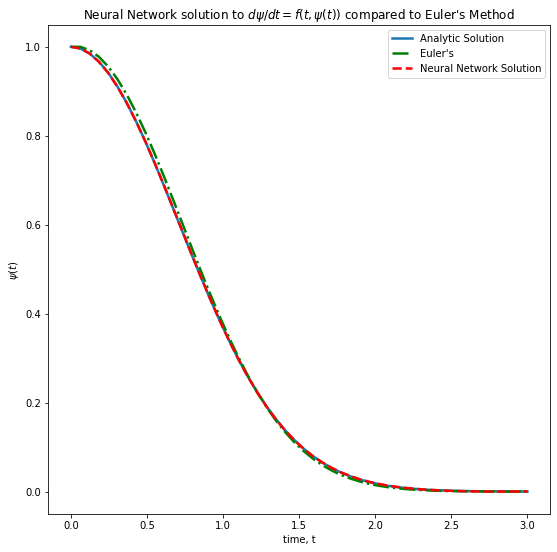



Average Percent Error from Analytic Solution
--------------------------------------------
Neural Network: 		 13.253 %
Euler's Method: 		 18.016 %






In [5]:
random.seed(6)
t = np.linspace(0, 3).reshape((-1, 1))
f0 = 1

def actual_dfdt(y, t):
    return -2 * t * y

# This is the function we seek to minimize
def obj3(params, step):
    # These should all be zero at the solution
    # This is our initial equation, df/dt = -2 * t * f(t)
    dfdt = elementwise_grad(approx_f, 1)
    zeq = dfdt(params, t) - (-2 * t * approx_f(params, t))
    ic = approx_f(params, 0) - f0 # returns a scalar, basically approx_f(0) - f(0)
    return np.mean(zeq**2) + ic**2 # returns a scalar

def callback(params, step, g):
    if step % 500 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      obj3(params, step)))
def analytic_fxn3(t):
    return 1 / np.exp((t**2))

ode_nn(num_iterations=2501, objective_fxn=obj3, hidden_layer_size=8, actual_dfdt=actual_dfdt, f0=f0,
       init_t=t, analytic_soln = analytic_fxn3, plot_num=3, step_size=0.01, scale=0.001)

___

$y'' = -11y' - 24y$

$y'(0) = 7$

$y(0) = 0$

In [8]:
def ode2_nn(num_iterations, objective_fxn, init_t, f0, f_prime0, scale=0.1, step_size = 0.001, 
           hidden_layer_size=8, analytic_soln=0, plot=True, plot_num=1):
    """
    Function to approximate first order ode using swish activation function
    with a single input value (x), a hidden layer, and a single output 
    """

    # Here is our initial guess of params:
    params = init_random_params(scale, layer_sizes=[1, hidden_layer_size, 1])
 
    t = init_t
    
    # Using the neural net to solve 
    params = adam(grad(objective_fxn), params,
              step_size=step_size, num_iters=num_iterations, callback=callback) 
    
    
    if plot == True:
        print("\n")
        plt.figure(figsize=(9,9))
        if analytic_soln:
            plt.plot(t, analytic_soln(t), label="Analytic Solution", lw=2.5)
        plt.plot(t, approx_f(params, t), 'r--', label="Neural Network Solution", lw=2.5)
        plt.xlabel("time, t")
        plt.ylabel("$ψ(t)$")
        plt.title("Neural Network solution to $dψ^2/d^2t = f(t, ψ(t), dψ/dt)$ compared to other methods")
        plt.legend()
        plt.savefig('nn-ode-' + str(plot_num) + '.png')
        plt.show()
        
        print("\n")
        print("Average Percent Error from Analytic Solution")
        print("--------------------------------------------")
        print("Neural Network:", "\t\t", round(total_error(analytic_soln(t), approx_f(params, t)) * 100, 3), "%")
        print("\n\n\n")
    else:
        return params

In [9]:
t = np.linspace(0,4).reshape((-1, 1))
f0 = -6
f_prim0 = -18


# This is the function we seek to minimize
def obj4(params, step):
    # These should all be zero at the solution
    # This is our initial equation, df/dt = -2 * t * f(t)
    dfdt = elementwise_grad(approx_f, 1)
    df2dt = elementwise_grad(dfdt, 1)
    zeq = 3*df2dt(params, t) + 2*dfdt(params, t) - 8*approx_f(params, t)
    ic1 = approx_f(params, 0) - f0 # returns a scalar, basically approx_f(0) - f(0)
    ic2 = dfdt(params, 0.0) - f_prime0
    ic = (ic1 + ic2) / 2
    return np.mean(zeq**2) + ic**2 # returns a scalar

def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      obj4(params, step)))
def analytic_fxn4(t):
    return (-9)*np.exp((4/3)*t) + (3)*np.exp((-2)*t)

ode2_nn(num_iterations=5001, objective_fxn=obj4, hidden_layer_size=8, f0=f0, f_prime0=f_prime0,
       init_t=t, analytic_soln = analytic_fxn4, plot_num=4, step_size=0.01, scale=0.1)

NameError: name 'f_prime0' is not defined